# Analysis and Presentation of the A/B test results 

In [3]:
import pandas as pd
from scipy.stats import chi2_contingency


In [5]:
data = pd.read_csv('ab_test_data.csv')


In [22]:
# Кількысть користувачів, конверсій та рівня конверсій у кожній групі
group_counts = data['test_group'].value_counts()

# Кількість конверсій у кожній групі
conversions = data.groupby('test_group')['conversion'].sum()

# Рівень конверсії у кожній групі
conversion_rates = data.groupby('test_group')['conversion'].mean() * 100

# Дата початку та завершення тесту
start_date = data['timestamp'].min()
end_date = data['timestamp'].max()
duration_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days

group_counts, conversions, conversion_rates, start_date, end_date, duration_days

(test_group
 a    10013
 b     9985
 Name: count, dtype: int64,
 test_group
 a    611
 b    889
 Name: conversion, dtype: int64,
 test_group
 a    6.102067
 b    8.903355
 Name: conversion, dtype: float64,
 '2023-07-03 01:42:34.033708',
 '2023-07-25 01:41:19.152664',
 21)

## Результати A/B тесту

 - Кількість користувачів у групах:

Група A: 10,013 користувачів
Група B: 9,985 користувачів

 - Кількість конверсій:

Група A: 611 конверсій
Група B: 889 конверсій

 - Рівень конверсії:

Група A: 6.10%
Група B: 8.90%

 - Дати тесту:

Початок: 3 липня 2023 року

Кінець: 25 липня 2023 року

Тривалість: 21 день

In [56]:
# Групові дані за тестовими групами
grouped_data = data.groupby('test_group')['conversion'].agg(['sum', 'count'])

# Обчислення кількості неконверсій
grouped_data['non_conversion'] = grouped_data['count'] - grouped_data['sum']

grouped_data.columns = ['conversions', 'total_users', 'non_conversions']
print(grouped_data)


            conversions  total_users  non_conversions
test_group                                           
a                   611        10013             9402
b                   889         9985             9096


> Chi-Square Test

In [24]:
# Create contingency table
contingency_table = [
    [grouped_data.loc['a', 'conversions'], grouped_data.loc['a', 'non_conversions']],
    [grouped_data.loc['b', 'conversions'], grouped_data.loc['b', 'non_conversions']]
]

# Chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2_stat)
print("P-Value:", p_value)


Chi-Square Statistic: 56.14249485320227
P-Value: 6.740440730497395e-14


In [26]:
if p_value < 0.05:
    print("The test results are statistically significant. Consider implementing the alternative design.")
else:
    print("The test results are not statistically significant. Stick with the control group for now.")


The test results are statistically significant. Consider implementing the alternative design.


Значення 56,14 свідчить про суттєву різницю між спостережуваними та очікуваними значеннями. 

P-значення:

Значення p-value становить 6,74e-14, що є надзвичайно малим. Це вказує на те, що ймовірність спостереження цього результату, якщо припустити нульову гіпотезу (відсутність різниці між групами), майже дорівнює нулю.

Висновок:

Оскільки p-значення набагато менше за загальноприйнятий поріг значущості (0,05), ми відхиляємо нульову гіпотезу.
Існує статистично значуща різниця в коефіцієнтах конверсії між групою А та групою B.


Виходячи з отриманих результатів, варто розглянути можливість впровадження пропозиції підписки зі знижкою (група B), оскільки вона, суттєво вплинула на коефіцієнт конверсії.

> T-Test

In [47]:
import numpy as np
from scipy.stats import ttest_ind

# Витягнення конверсій для кожної групи
group_a = data[data['test_group'] == 'a']['conversion']
group_b = data[data['test_group'] == 'b']['conversion']

# Проведення т-тесту
t_stat, p_value = ttest_ind(group_a, group_b)

print(f"T-статистика: {t_stat:.4f}")
print(f"P-значення: {p_value:.4f}")

# Висновок про відхилення або прийняття нульової гіпотези
if p_value < 0.05:
    print("Нульову гіпотезу можна відхилити: конверсії в групах A та B статистично значущі.")
else:
    print("Немає підстав для відхилення нульової гіпотези: конверсії в групах A та B не мають статистично значущих відмінностей.")


T-статистика: -7.5300
P-значення: 0.0000
Нульову гіпотезу можна відхилити: конверсії в групах A та B статистично значущі.


>Visualization comparing the conversion rates in Group A and Group B, along with 95% confidence intervals


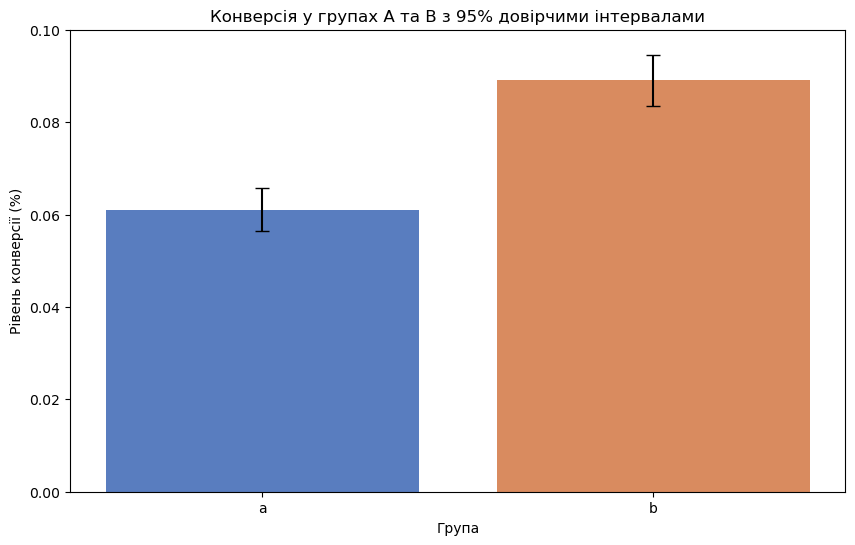

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Обчислення довірчих інтервалів
conversion_rates = data.groupby('test_group')['conversion'].mean()
std_error = data.groupby('test_group')['conversion'].std() / np.sqrt(data.groupby('test_group')['conversion'].count())
conf_intervals = std_error * 1.96  # 95% довірчий інтервал

# Побудова графіка
plt.figure(figsize=(10, 6))
sns.barplot(x=conversion_rates.index, y=conversion_rates.values, capsize=0.1, palette="muted", hue=conversion_rates.index, dodge=False, legend=False)
plt.errorbar(conversion_rates.index, conversion_rates.values, yerr=conf_intervals.values, fmt='none', capsize=5, color='black')
plt.title("Конверсія у групах A та B з 95% довірчими інтервалами")
plt.xlabel("Група")
plt.ylabel("Рівень конверсії (%)")
plt.ylim(0, 0.1)
plt.show()


## Висновки з A/B тесту

 - Ми порівнюємо ефективність двох пропозицій підписки на застосунок:

Група A: Підписка за $4.99

Група B: Підписка з припискою про знижку 50%


 - Мета тесту - збільшити конверсію з інстала в платіж, аби більше користувачів підписувались на преміум-функції застосунку.

 - Гіпотеза:

Пропозиція з припискою про знижку 50% (група B) призведе до вищої конверсії порівняно зі стандартною пропозицією (група A).

 - Цільова аудиторія:

Нові користувачі застосунку з усіх геолокацій.

 - Аналіз результатів:

Цільова метрика - Конверсія:

Група A: Конверсія - 6.10%

Група B: Конверсія - 8.90%

Т-статистика: -7.5300

P-значення: 0.0000

 - Висновок: Конверсії в групах A та B статистично значущі, тобто пропозиція зі знижкою 50% значно ефективніша.

 - Додаткові метрики:

Ми припустили, що додаткові метрики не зазнали значних змін. Для повного аналізу можна було б включити утримання користувачів, користувацький досвід, середній дохід на користувача (ARPU) тощо.

 - Візуалізація:

Наш графік з 95% довірчими інтервалами чітко демонструє, що конверсія в групі B значно вища.

 - Рекомендації:

Успіх тесту дозволяє рекомендувати впровадження пропозиції зі знижкою 50% для всіх нових користувачів.

 - Подальші дії:

Провести додаткові тести для інших груп користувачів (наприклад, довгострокові користувачі).

Аналізувати вплив нової пропозиції на довгострокове утримання користувачів та інші ключові метрики.

 - Додаткові інсайти:

Результати цього тесту можуть бути використані для генерації нових гіпотез, наприклад, експериментів з іншими типами знижок або персоналізованих пропозицій.

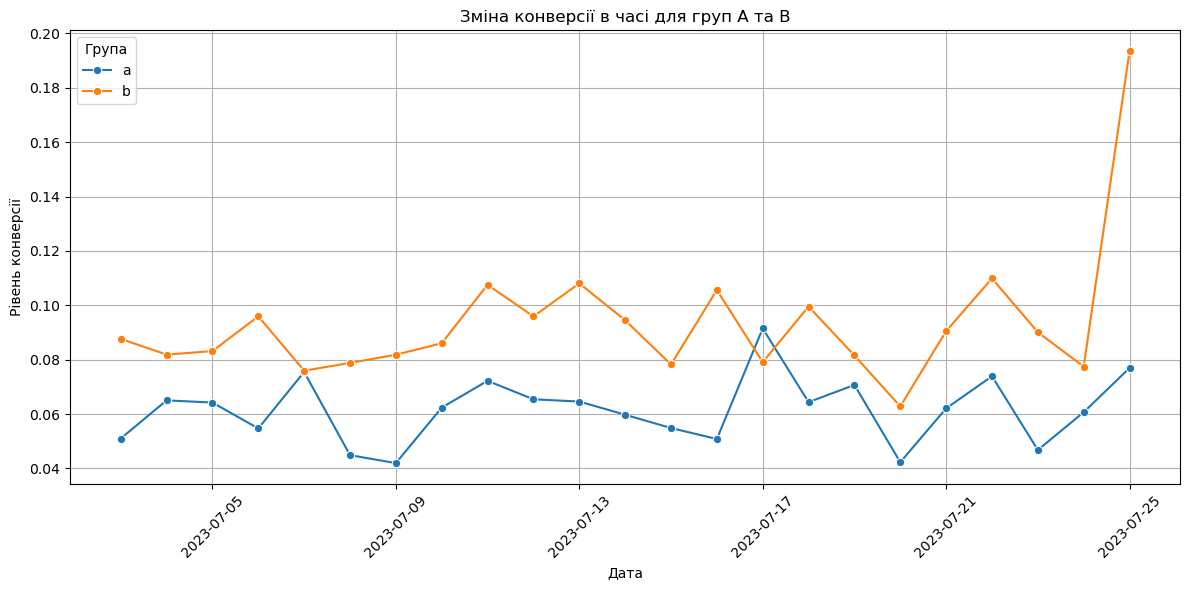

In [61]:

# Зміна формату дати та часу
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Додавання колонки з датою без часу
data['date'] = data['timestamp'].dt.date

# Обчислення щоденної конверсії для кожної групи
daily_conversion = data.groupby(['date', 'test_group'])['conversion'].mean().reset_index()

# Побудова графіка
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='conversion', hue='test_group', data=daily_conversion, marker='o')
plt.title("Зміна конверсії в часі для груп A та B")
plt.xlabel("Дата")
plt.ylabel("Рівень конверсії")
plt.xticks(rotation=45)
plt.legend(title='Група')
plt.grid(True)
plt.tight_layout()
plt.show()
